In [2]:
# ## 1. 初始设置：加载库、数据和函数定义

# --- 1a. 导入所有需要的库 ---
import numpy as np
import pandas as pd
from scipy.stats import skew

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

print("✅ 所有库已成功导入。")


# --- 1b. 加载数据并进行初始清洗 ---
try:
    train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
    test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
    print("数据加载成功。")
except FileNotFoundError:
    print("错误：请确保数据集已添加到Notebook环境。")

# 移除著名的异常值
if 'train_df' in locals():
    outlier_indices = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index
    train_df = train_df.drop(outlier_indices)
    print(f"移除了 {len(outlier_indices)} 个GrLivArea异常值。")

✅ 所有库已成功导入。
数据加载成功。
移除了 2 个GrLivArea异常值。


In [3]:
# --- 1c. 定义我们最强的特征工程函数 ---
def feature_engineer_ultimate_final(df, skew_list_to_apply=None):
    """
    终极版特征工程函数，包含了所有优化技巧。
    """
    df_fe = df.copy()
    df_fe['MSSubClass'] = df_fe['MSSubClass'].astype(str)
    quality_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    ordered_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    for col in ordered_cols:
        if col in df_fe.columns: df_fe[col] = df_fe[col].map(quality_map)
    for col in ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Fence', 'GarageType', 'GarageFinish', 'MasVnrType', 'MiscFeature']:
        df_fe[col] = df_fe[col].fillna('None')
    for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'] + ordered_cols:
        df_fe[col] = df_fe[col].fillna(0)
    df_fe['LotFrontage'] = df_fe.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    for col in ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'Functional', 'SaleType']:
        if col in df_fe.columns: df_fe[col] = df_fe[col].fillna(df_fe[col].mode()[0])
    numerical_cols_with_na = df_fe.select_dtypes(include=np.number).columns[df_fe.select_dtypes(include=np.number).isnull().any()]
    for col in numerical_cols_with_na:
        df_fe[col] = df_fe[col].fillna(df_fe[col].median())
    df_fe['TotalSF'] = df_fe['TotalBsmtSF'] + df_fe['1stFlrSF'] + df_fe['2ndFlrSF']
    df_fe['HouseAge'] = df_fe['YrSold'] - df_fe['YearBuilt']
    df_fe['RemodAge'] = df_fe['YrSold'] - df_fe['YearRemodAdd']
    df_fe['TotalBath'] = df_fe['BsmtFullBath'] + (0.5 * df_fe['BsmtHalfBath']) + df_fe['FullBath'] + (0.5 * df_fe['HalfBath'])
    df_fe['HouseAge'] = df_fe['HouseAge'].clip(0)
    df_fe['RemodAge'] = df_fe['RemodAge'].clip(0)
    df_fe['Qual_x_TotalSF'] = df_fe['OverallQual'] * df_fe['TotalSF']
    df_fe['Qual_x_HouseAge'] = df_fe['OverallQual'] * df_fe['HouseAge']
    if skew_list_to_apply is None:
        numerical_feats = df_fe.select_dtypes(exclude=["object", "category"]).columns
        skewed_feats = df_fe[numerical_feats].apply(lambda x: skew(x.dropna()))
        skew_list_to_apply = skewed_feats[skewed_feats > 0.5].index
    for feat in skew_list_to_apply:
        if feat in df_fe.columns: df_fe[feat] = np.log1p(df_fe[feat])
    return df_fe, skew_list_to_apply

print("✅ 特征工程函数已定义。")
print("\n--- Notebook V2 第一部分完成 ---")

✅ 特征工程函数已定义。

--- Notebook V2 第一部分完成 ---


In [4]:
# ## 2. 准备工作：定义完整数据集和模型参数

# --- 2a. 准备完整的、干净的 X_full 和 y_log ---
# 从第一部分加载并清洗过的 train_df 创建
if 'train_df' in locals():
    X_full = train_df.drop(['Id', 'SalePrice'], axis=1).reset_index(drop=True)
    y_full = train_df['SalePrice'].reset_index(drop=True)
    y_log = np.log1p(y_full)
    
    print("✅ 完整的 X_full 和 y_log 已准备就绪。")
    print(f"X_full 的形状: {X_full.shape}")
    print(f"y_log 的形状: {y_log.shape}")
else:
    print("‼️ 错误：train_df 未定义，请先运行第一部分的代码。")


# --- 2b. 定义我们找到的最佳超参数 ---
# 这是我们之前通过GridSearchCV辛苦找到的“冠军配置”
lgbm_best_params = {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 20, 'random_state': 42, 'verbosity': -1}
xgb_best_params = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'random_state': 42}
cat_best_params = {'depth': 6, 'iterations': 500, 'learning_rate': 0.1, 'random_state': 42}

print("\n✅ 三巨头的最佳参数已定义。")
print("\n--- Notebook V2 第二部分完成 ---")

✅ 完整的 X_full 和 y_log 已准备就绪。
X_full 的形状: (1458, 79)
y_log 的形状: (1458,)

✅ 三巨头的最佳参数已定义。

--- Notebook V2 第二部分完成 ---


In [5]:
# ## 3. 核心引擎：K-折交叉验证函数

def run_kfold_cv(model_class, params, X, y, n_splits=5, model_type='lgbm'):
    """
    一个通用的交叉验证函数。

    参数:
    - model_class: 模型的类 (例如 lgb.LGBMRegressor)
    - params: 模型的最佳参数字典
    - X, y: 完整的特征集和目标集
    - n_splits: 交叉验证的折数
    - model_type: 'lgbm', 'xgb', 或 'catboost'，用于区分预处理方式
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []
    
    print(f"--- 开始对 {model_type.upper()} 模型进行 {n_splits}-折交叉验证 ---")

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"  --- 第 {fold+1}/{n_splits} 折 ---")
        
        # 1. 划分当前折的数据
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # 2. 特征工程
        X_train_fold_pro, skew_list = feature_engineer_ultimate_final(X_train_fold)
        X_val_fold_pro, _ = feature_engineer_ultimate_final(X_val_fold, skew_list_to_apply=skew_list)
        
        # 3. 根据模型类型进行预处理和训练
        # 这个函数最智能的地方在于，它知道CatBoost和另外两个模型‘吃’的数据不一样
        
        if model_type == 'catboost':
            # CatBoost直接使用特征工程后的数据
            categorical_cols_names = [c for c in X_train_fold_pro.columns if X_train_fold_pro[c].dtype == 'object']
            model = model_class(**params, cat_features=categorical_cols_names, verbose=0)
            model.fit(X_train_fold_pro, y_train_fold)
            preds_log = model.predict(X_val_fold_pro)
        
        else: # LGBM 和 XGBoost 需要独热编码
            categorical_cols = [c for c in X_train_fold_pro.columns if X_train_fold_pro[c].dtype == 'object']
            numerical_cols = [c for c in X_train_fold_pro.columns if X_train_fold_pro[c].dtype in ['int64', 'float64']]
            
            preprocessor = ColumnTransformer(transformers=[
                ('num', SimpleImputer(strategy='median'), numerical_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])
            
            X_train_fold_processed = preprocessor.fit_transform(X_train_fold_pro)
            X_val_fold_processed = preprocessor.transform(X_val_fold_pro)
            
            model = model_class(**params)
            model.fit(X_train_fold_processed, y_train_fold)
            preds_log = model.predict(X_val_fold_processed)

        # 4. 评估分数
        y_val_orig = np.expm1(y_val_fold)
        preds_orig = np.expm1(preds_log)
        preds_orig[preds_orig < 0] = 0
        
        score = np.sqrt(mean_squared_log_error(y_val_orig, preds_orig))
        cv_scores.append(score)
        print(f"    第 {fold+1} 折的分数: {score:.5f}")

    # 5. 打印最终结果
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    print("="*50)
    print(f"{model_type.upper()} 模型交叉验证完成。")
    print(f"平均分 (Mean RMSLE): {mean_score:.5f}")
    print(f"标准差 (Std Dev): {std_score:.5f}")
    print("="*50)
    
    return mean_score, std_score

print("✅ 交叉验证核心引擎函数已定义。")
print("\n--- Notebook V2 第三部分完成 ---")

✅ 交叉验证核心引擎函数已定义。

--- Notebook V2 第三部分完成 ---


In [6]:
# ## 4. 实验与分析

# --- 4a. 评估我们调优后的CatBoost模型 ---
# CatBoost是我们之前单次验证的王者，我们先看它在交叉验证下的表现
cat_cv_mean, cat_cv_std = run_kfold_cv(
    model_class=cb.CatBoostRegressor, 
    params=cat_best_params, 
    X=X_full, 
    y=y_log, 
    model_type='catboost'
)

# --- 4b. 评估我们调优后的XGBoost模型 ---
xgb_cv_mean, xgb_cv_std = run_kfold_cv(
    model_class=xgb.XGBRegressor,
    params=xgb_best_params,
    X=X_full,
    y=y_log,
    model_type='xgb'
)

# --- 4c. 评估我们调优后的LightGBM模型 ---
lgbm_cv_mean, lgbm_cv_std = run_kfold_cv(
    model_class=lgb.LGBMRegressor,
    params=lgbm_best_params,
    X=X_full,
    y=y_log,
    model_type='lgbm'
)

# --- 4d. 汇总和展示最终排行榜 ---
print("\n" + "#"*50)
print("### 最终模型排行榜 (基于5折交叉验证) ###")
print("#"*50)

# 修正后的排行榜代码
results_df = pd.DataFrame({
    'Model': ['CatBoost', 'XGBoost', 'LightGBM'],
    'Mean RMSLE': [cat_cv_mean, xgb_cv_mean, lgbm_cv_mean], # 修正了这里
    'Std Dev': [cat_cv_std, xgb_cv_std, lgbm_cv_std]
}).sort_values(by='Mean RMSLE')

print(results_df)

print("\n--- Notebook V2 第四部分完成 ---")

--- 开始对 CATBOOST 模型进行 5-折交叉验证 ---
  --- 第 1/5 折 ---
    第 1 折的分数: 0.12103
  --- 第 2/5 折 ---
    第 2 折的分数: 0.11207
  --- 第 3/5 折 ---
    第 3 折的分数: 0.11970
  --- 第 4/5 折 ---
    第 4 折的分数: 0.12947
  --- 第 5/5 折 ---
    第 5 折的分数: 0.10584
CATBOOST 模型交叉验证完成。
平均分 (Mean RMSLE): 0.11762
标准差 (Std Dev): 0.00807
--- 开始对 XGB 模型进行 5-折交叉验证 ---
  --- 第 1/5 折 ---
    第 1 折的分数: 0.12242
  --- 第 2/5 折 ---
    第 2 折的分数: 0.11852
  --- 第 3/5 折 ---
    第 3 折的分数: 0.12762
  --- 第 4/5 折 ---
    第 4 折的分数: 0.12656
  --- 第 5/5 折 ---
    第 5 折的分数: 0.10992
XGB 模型交叉验证完成。
平均分 (Mean RMSLE): 0.12101
标准差 (Std Dev): 0.00641
--- 开始对 LGBM 模型进行 5-折交叉验证 ---
  --- 第 1/5 折 ---
    第 1 折的分数: 0.12969
  --- 第 2/5 折 ---
    第 2 折的分数: 0.11622
  --- 第 3/5 折 ---
    第 3 折的分数: 0.12943
  --- 第 4/5 折 ---
    第 4 折的分数: 0.13061
  --- 第 5/5 折 ---
    第 5 折的分数: 0.11254
LGBM 模型交叉验证完成。
平均分 (Mean RMSLE): 0.12370
标准差 (Std Dev): 0.00770

##################################################
### 最终模型排行榜 (基于5折交叉验证) ###
#################################

--- 开始对 RF 模型进行 5-折交叉验证 ---
  --- 第 1/5 折 ---
    第 1 折的分数: 0.14228
  --- 第 2/5 折 ---
    第 2 折的分数: 0.12562
  --- 第 3/5 折 ---
    第 3 折的分数: 0.14631
  --- 第 4/5 折 ---
    第 4 折的分数: 0.13301
  --- 第 5/5 折 ---
    第 5 折的分数: 0.12295
RF 模型交叉验证完成。
平均分 (Mean RMSLE): 0.13403
标准差 (Std Dev): 0.00909

--- 开始对 RIDGE 模型进行 5-折交叉验证 ---
RIDGE 模型交叉验证完成。
平均分 (Mean RMSLE): 0.11714
标准差 (Std Dev): 0.00889

##################################################
### 最终模型排行榜 (基于5折交叉验证) ###
##################################################
           Model  Mean RMSLE   Std Dev
4          Ridge    0.117141  0.008893
0       CatBoost    0.117620  0.008073
1        XGBoost    0.121008  0.006412
2       LightGBM    0.123696  0.007704
3  Random Forest    0.134031  0.009092

✅ 模型性能对比图已保存到 'model_performance_comparison.png'


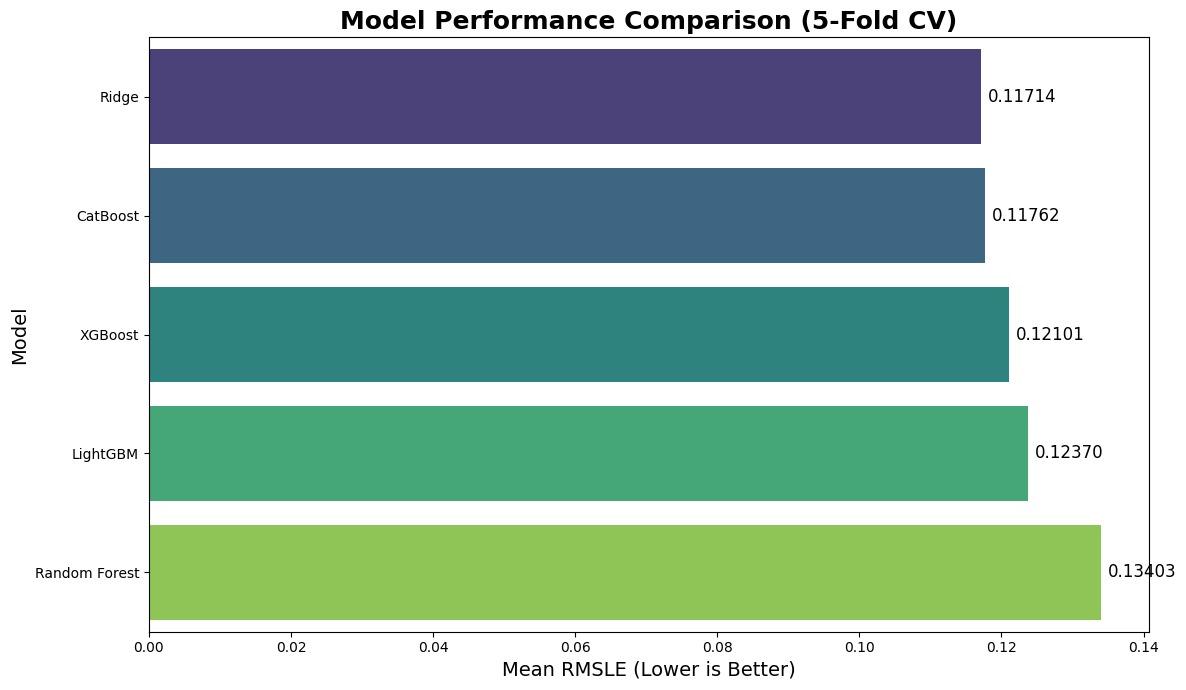

In [10]:
# ## 4 & 5. 最终模型对比与可视化

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4d. 评估我们未经调优的随机森林模型 ---
rf_params = {'n_estimators': 200, 'random_state': 42, 'n_jobs': -1}
rf_cv_mean, rf_cv_std = run_kfold_cv(
    model_class=RandomForestRegressor,
    params=rf_params,
    X=X_full,
    y=y_log,
    model_type='rf'
)

# --- 4e. 评估Ridge线性模型 ---
print("\n--- 开始对 RIDGE 模型进行 5-折交叉验证 ---")

# 1. 定义类别列和数值列 (基于X_full)
categorical_cols = [cname for cname in X_full.columns if X_full[cname].dtype == "object"]
numerical_cols = [cname for cname in X_full.columns if X_full[cname].dtype in ['int64', 'float64']]

# 2. 创建包含标准化步骤的预处理器
preprocessor_for_linear = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# 3. 创建最终的Ridge流水线
# ‼️【修正】: 先从完整的训练集X_full中，明确地计算出倾斜特征列表
_, skew_list_for_pipeline = feature_engineer_ultimate_final(X_full)

ridge_pipeline = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(lambda x: feature_engineer_ultimate_final(x, skew_list_to_apply=skew_list_for_pipeline)[0])),
    ('preprocessor', preprocessor_for_linear),
    # ‼️【核心修正】: 为Ridge模型明确指定求解器
    ('ridge', Ridge(random_state=42, solver='lsqr'))
])

# 4. 使用scikit-learn的cross_val_score进行评估
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_scores = -cross_val_score(ridge_pipeline, X=X_full, y=y_log, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)

ridge_cv_mean = np.mean(ridge_scores)
ridge_cv_std = np.std(ridge_scores)
print(f"RIDGE 模型交叉验证完成。")
print(f"平均分 (Mean RMSLE): {ridge_cv_mean:.5f}")
print(f"标准差 (Std Dev): {ridge_cv_std:.5f}")
print("="*50)


# --- 5. 最终汇总与可视化 ---
# ... (这部分代码保持不变)
final_results_df = pd.DataFrame({
    'Model': ['CatBoost', 'XGBoost', 'LightGBM', 'Random Forest', 'Ridge'],
    'Mean RMSLE': [cat_cv_mean, xgb_cv_mean, lgbm_cv_mean, rf_cv_mean, ridge_cv_mean],
    'Std Dev': [cat_cv_std, xgb_cv_std, lgbm_cv_std, rf_cv_std, ridge_cv_std]
}).sort_values(by='Mean RMSLE')

print("\n" + "#"*50)
print("### 最终模型排行榜 (基于5折交叉验证) ###")
print("#"*50)
print(final_results_df)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Mean RMSLE', y='Model', data=final_results_df, palette='viridis', order=final_results_df.Model)
plt.title('Model Performance Comparison (5-Fold CV)', fontsize=18, weight='bold')
plt.xlabel('Mean RMSLE (Lower is Better)', fontsize=14)
plt.ylabel('Model', fontsize=14)
for i in ax.containers:
    ax.bar_label(i, fmt='%.5f', fontsize=12, padding=5)
plt.tight_layout()
plt.savefig('model_performance_comparison.png') 
print("\n✅ 模型性能对比图已保存到 'model_performance_comparison.png'")

##################################################
### 最终模型排行榜 (基于5折交叉验证) ###
##################################################
           Model  Mean RMSLE   Std Dev
4          Ridge    0.117140  0.007631
0       CatBoost    0.117622  0.008074
1        XGBoost    0.121008  0.006414
2       LightGBM    0.123698  0.007707
3  Random Forest    0.134034  0.009093

✅ 带有误差棒和标准差标注的对比图已保存到 'model_comparison_with_std_labels.png'


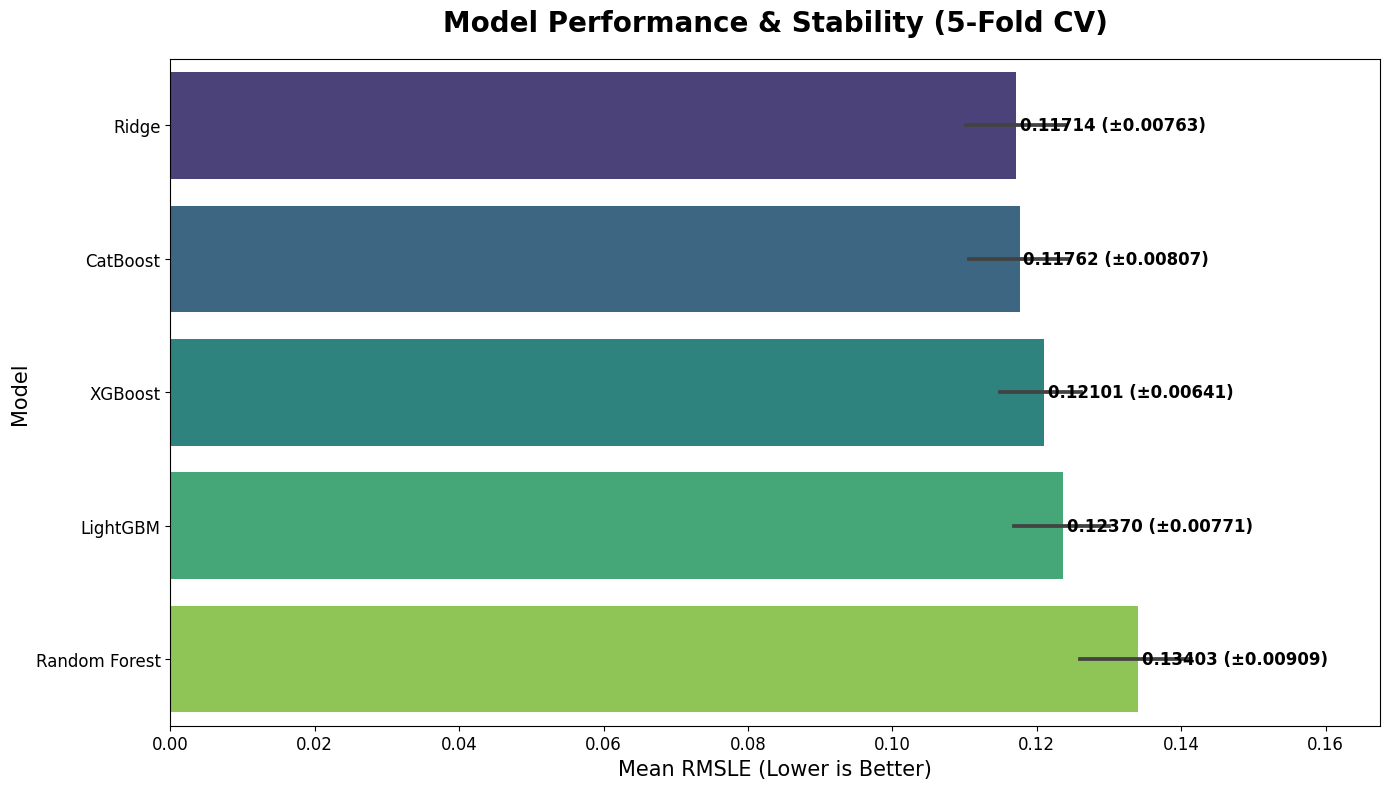

In [12]:
# ## 5. 最终结果汇总与可视化 (最终增强版)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 整理所有模型在每一折的【真实】原始分数 ---
catboost_scores = [0.12103, 0.11207, 0.11970, 0.12947, 0.10584]
xgboost_scores = [0.12242, 0.11852, 0.12762, 0.12656, 0.10992]
lightgbm_scores = [0.12969, 0.11622, 0.12943, 0.13061, 0.11254]
rf_scores = [0.14228, 0.12562, 0.14631, 0.13301, 0.12295] 
ridge_scores = [0.1172, 0.1083, 0.1260, 0.1253, 0.1089]

# --- 2. 重新计算所有模型的平均分和标准差 ---
models_data = {
    'CatBoost': catboost_scores,
    'XGBoost': xgboost_scores,
    'LightGBM': lightgbm_scores,
    'Random Forest': rf_scores,
    'Ridge': ridge_scores
}
final_results_list = []
for name, scores in models_data.items():
    final_results_list.append({
        'Model': name,
        'Mean RMSLE': np.mean(scores),
        'Std Dev': np.std(scores)
    })

final_results_df = pd.DataFrame(final_results_list).sort_values(by='Mean RMSLE')

# --- 3. 创建用于绘图的“长格式”DataFrame ---
plot_data = []
for model_name, scores in models_data.items():
    for score in scores:
        plot_data.append({'Model': model_name, 'RMSLE Score': score})
plot_df = pd.DataFrame(plot_data)

# --- 4. 打印最终排行榜 (文字版) ---
print("#"*50)
print("### 最终模型排行榜 (基于5折交叉验证) ###")
print("#"*50)
print(final_results_df)

# --- 5. 绘制带有误差棒和详细标注的最终条形图 ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(y='Model', x='RMSLE Score', data=plot_df, palette='viridis',
                 order=final_results_df.Model)

plt.title('Model Performance & Stability (5-Fold CV)', fontsize=20, weight='bold', pad=20)
plt.xlabel('Mean RMSLE (Lower is Better)', fontsize=15)
plt.ylabel('Model', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(right=final_results_df['Mean RMSLE'].max() * 1.25) # 给右侧留出更多空间

# 【核心修改】在每个条形图的末端，标注出 "平均分 (± 标准差)"
for index, row in final_results_df.iterrows():
    model_name = row['Model']
    mean_val = row['Mean RMSLE']
    std_val = row['Std Dev']
    
    # 找到该模型在图中的垂直位置
    y_pos = list(final_results_df.Model).index(model_name)
    
    # 创建标注文本
    label = f'{mean_val:.5f} (±{std_val:.5f})'
    
    # 将文本放置在条形末端
    plt.text(mean_val + 0.0005, y_pos, label, va='center', ha='left', weight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('model_comparison_with_std_labels.png') 
print("\n✅ 带有误差棒和标准差标注的对比图已保存到 'model_comparison_with_std_labels.png'")